# EDA Housing prices
## focusing on EDA + filling NANs

##### in this notebook I will focus on  understanding the data and filling in the nan values in a proposed method.<br> Some new ideas will be tested here such as heatmaps for relationship between categorical variables and considering data imputation as a prediction problem within itselfe.

#### focuses:
##### EDA:
In the EDA part I will:
- Examine if the year variables need to be categorical.
- Get a sense of relationship between categorical variables and target variable.
- Get a sense of relationship between the categorical variables themselves using a heatmap to plot the p value of chi square tests.

##### NAN (data imputation):
In the part to fill out the nans I will:
- Understand which nans are real and which are another category according to the data description.
- Use the following method for filling out the real NANs:
> - I will regard each NAN as another prediction problem, I will use xgboost to try predict the missing values. This poses a few challanges: <br>
> > 1. when training a model for a specific variable I will have other variables that are missing, so this is a recursive problem, hence I need to find a solution.
> > 2. defrentiating between categorical (**classification** problems) and numerical (**regression** problems)
> - The way I will overcome these challanges:
> > 1. I will sort the nanful variables according to the frequency of nans in a decenting order and will loop over the list and handle them by order, When handeling each variable I will drop the samples containing nans of other variables. This way I will reduce the amound of sample drops needed to predict a given nan. Before doing so I need to check if it is worth it dropping the variable in itselfe instead of dropping the samples - this will be done in the EDA step by plotting heatmaps.
> > 2. I will create an object which handles filling nans and it has two models - one for classification tasks and the other for regression problems.


In [256]:
%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt


train = pd.read_csv("train.csv")
train = train.sample(frac=1).reset_index(drop=True)
test = pd.read_csv("test.csv")
X_train = train.drop(axis=1, labels=['SalePrice'])
combine_lst = [X_train, test]
combine_df = pd.concat(combine_lst)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [257]:
train.shape

(1460, 81)

do I need to change the "year" columns to be categorical?<br>
this depends how the variables move with the target variable.

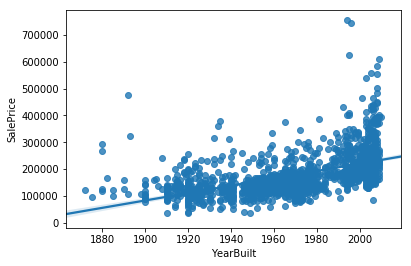

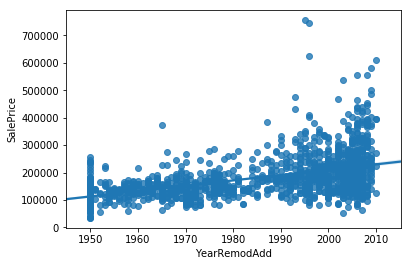

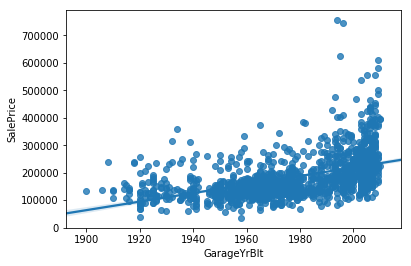

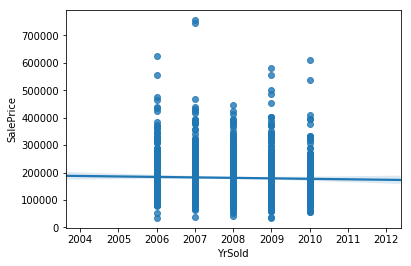

In [258]:
year_vars = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']
for var in year_vars:
    plt.clf()
    sns.regplot(train[var], train['SalePrice'])
    plt.show()

even though it looks as though YrSold range is much smaller and that is the reaon it looks like categorical, I will still turn it into categorical.
The rest of the variables look like they have a clear correlation with SalePrice so we will not change them

In [259]:
for df in combine_lst:
    df['YrSold'] = df['YrSold'].astype('object')
    df['YrSold'].describe()
combine_df = pd.concat(combine_lst)

In [260]:
for df in combine_lst:
    df['GarageYrBlt'] = df['GarageYrBlt'].astype('object')
    df['GarageYrBlt'].describe()
combine_df = pd.concat(combine_lst)

split into categorical and numerical

In [261]:
numerical = combine_df.drop(columns=['Id']).select_dtypes(['float64', 'int64']).columns.values
numerical

array(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold'], dtype=object)

In [262]:
categorical = combine_df.select_dtypes(['object']).columns.values
categorical

array(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence',
       'MiscFeature', 'YrSold', 'SaleType', 'SaleCondition'], dtype=object)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text xticklabel objects>)

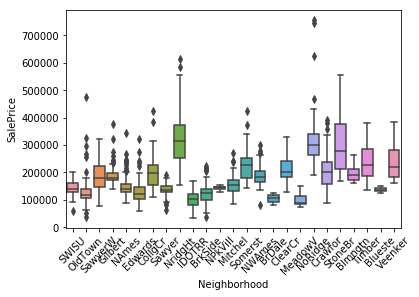

In [263]:
sns.boxplot(x=train['Neighborhood'], y=train['SalePrice'])
plt.xticks(rotation=45)

plotting: MSZoning


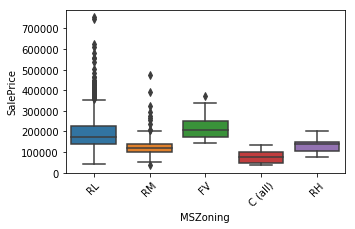

plotting: Street


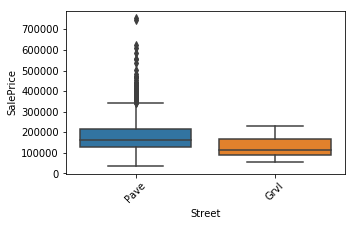

plotting: Alley


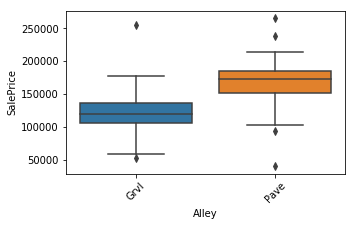

plotting: LotShape


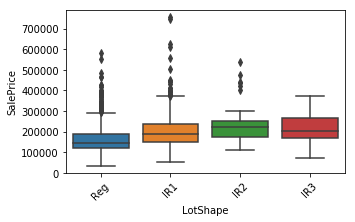

plotting: LandContour


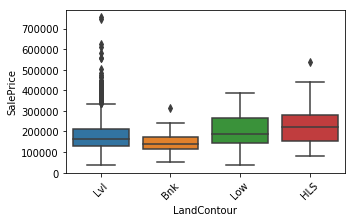

plotting: Utilities


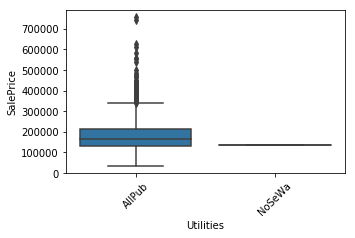

plotting: LotConfig


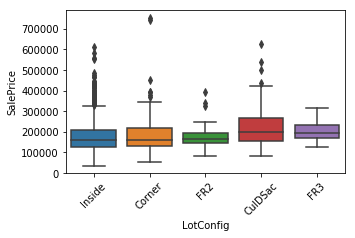

plotting: LandSlope


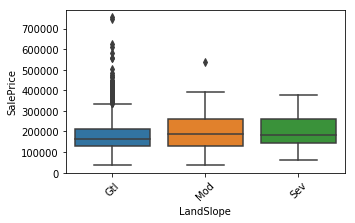

plotting: Neighborhood


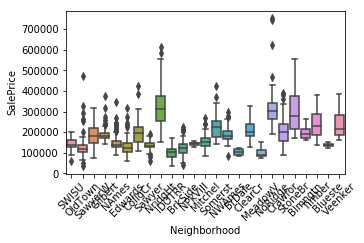

plotting: Condition1


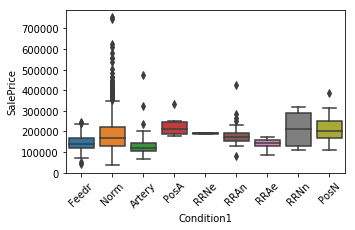

plotting: Condition2


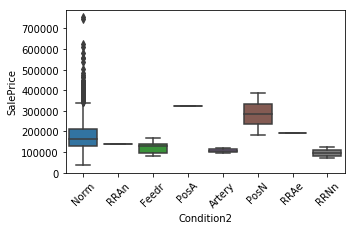

plotting: BldgType


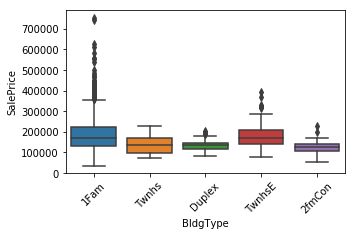

plotting: HouseStyle


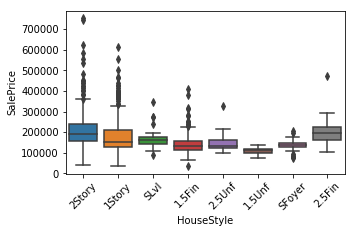

plotting: RoofStyle


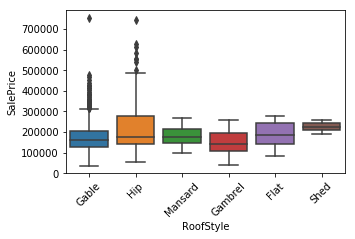

plotting: RoofMatl


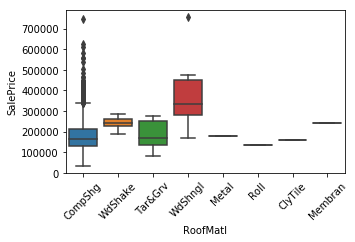

plotting: Exterior1st


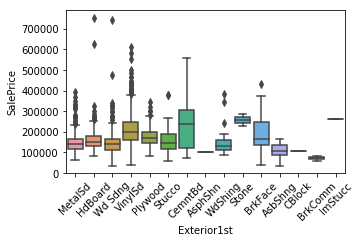

plotting: Exterior2nd


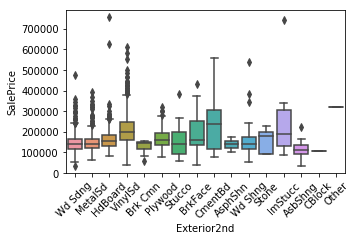

plotting: MasVnrType


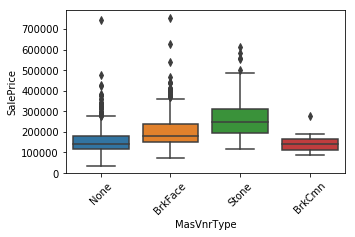

plotting: ExterQual


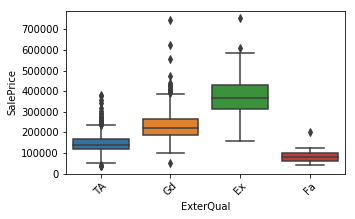

plotting: ExterCond


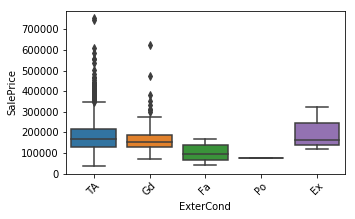

plotting: Foundation


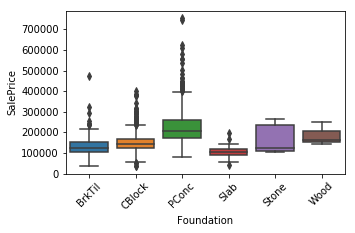

plotting: BsmtQual


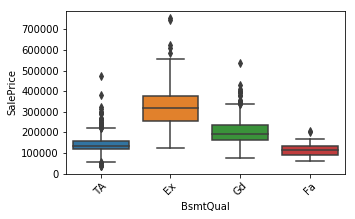

plotting: BsmtCond


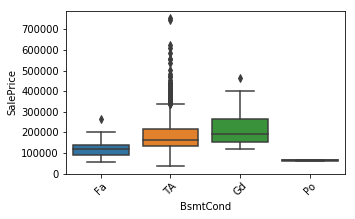

plotting: BsmtExposure


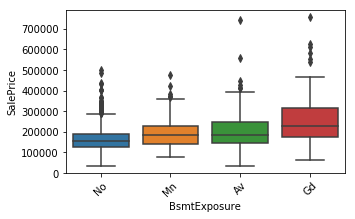

plotting: BsmtFinType1


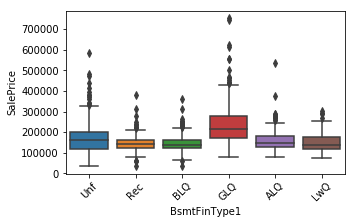

plotting: BsmtFinType2


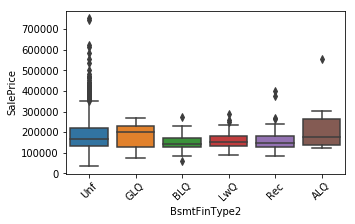

plotting: Heating


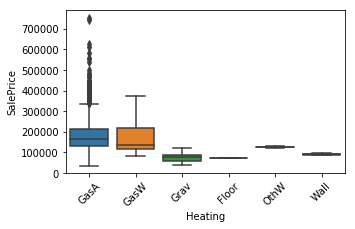

plotting: HeatingQC


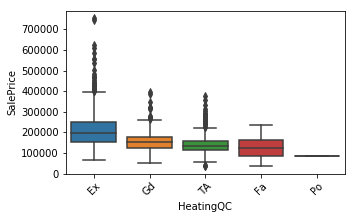

plotting: CentralAir


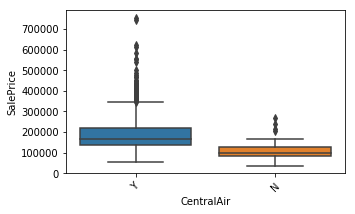

plotting: Electrical


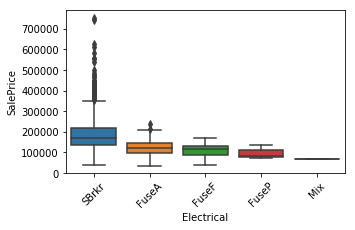

plotting: KitchenQual


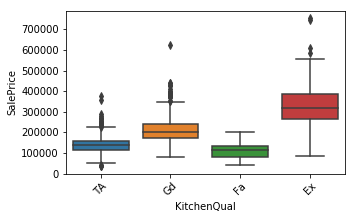

plotting: Functional


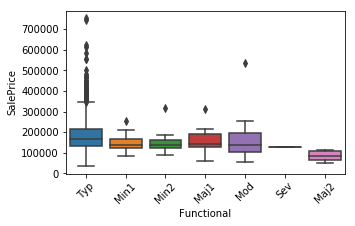

plotting: FireplaceQu


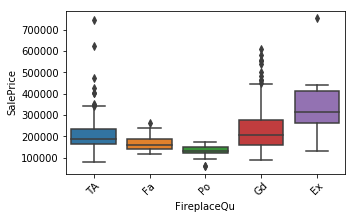

plotting: GarageType


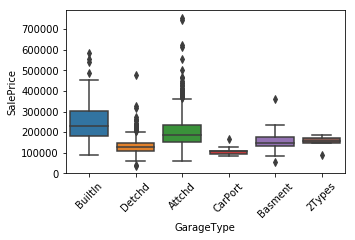

plotting: GarageYrBlt


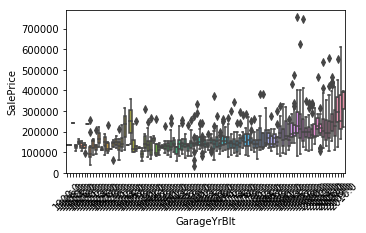

plotting: GarageFinish


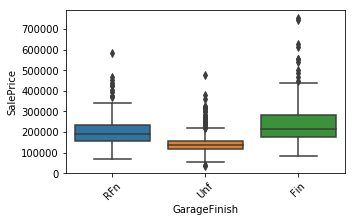

plotting: GarageQual


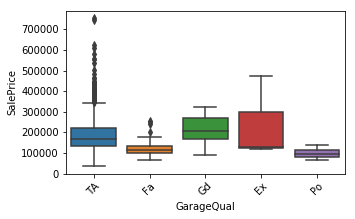

plotting: GarageCond


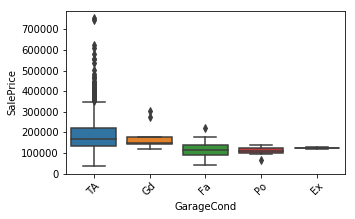

plotting: PavedDrive


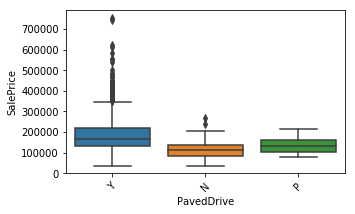

plotting: PoolQC


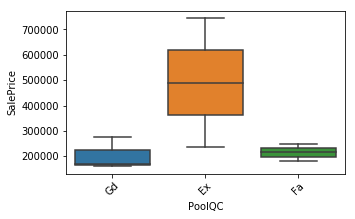

plotting: Fence


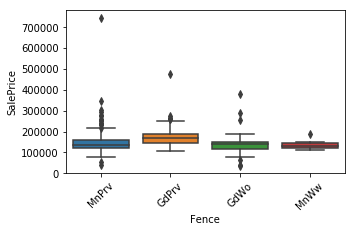

plotting: MiscFeature


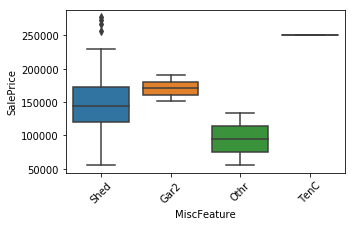

plotting: YrSold


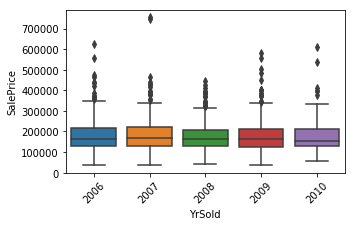

plotting: SaleType


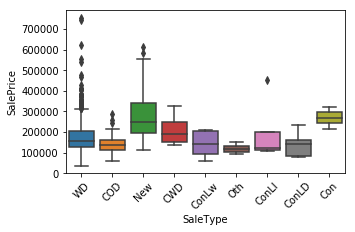

plotting: SaleCondition


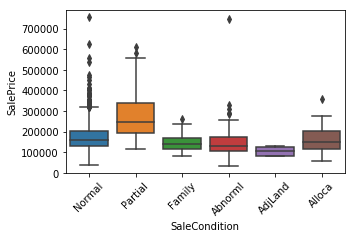

In [264]:
#train.dropna(axis=0, inplace=True)
#sns.set()
#cols = categorical
#g = sns.FacetGrid(train, x_vars=cols, y_vars=['SalePrice'], size=5)
#g.map(sns.boxplot)
for cat in categorical:
    print("plotting: " + cat)
    #print(train[cat].dtype.name)
    fig, ax = plt.subplots()
    f = fig.set_size_inches(5, 3)
    g = sns.boxplot(x=cat, y="SalePrice", data=train, ax=ax)
    plt.xticks(rotation=45)
    plt.show()
    plt.clf()

change NANs to their propper value

In [265]:
nan_cols = combine_df.columns[combine_df.isna().any()].tolist()
nan_cols

['MSZoning',
 'LotFrontage',
 'Alley',
 'Utilities',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'Electrical',
 'BsmtFullBath',
 'BsmtHalfBath',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType']

In [266]:
combine_df[nan_cols].isnull().sum()

MSZoning           4
LotFrontage      486
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
dtype: int64

lets see if the NANs found are real NANs or perhaps they indicate 0 or none

In [267]:
categorical_nans = []
for col in nan_cols:
    if col in categorical:
        print(str(col) + ": " + str(combine_df[col].unique()))
        categorical_nans.append(col)

MSZoning: ['RL' 'RM' 'FV' 'C (all)' 'RH' nan]
Alley: [nan 'Grvl' 'Pave']
Utilities: ['AllPub' 'NoSeWa' nan]
Exterior1st: ['MetalSd' 'HdBoard' 'Wd Sdng' 'VinylSd' 'Plywood' 'Stucco' 'CemntBd'
 'AsphShn' 'WdShing' 'Stone' 'BrkFace' 'AsbShng' 'CBlock' 'BrkComm'
 'ImStucc' nan]
Exterior2nd: ['Wd Sdng' 'MetalSd' 'HdBoard' 'VinylSd' 'Brk Cmn' 'Plywood' 'Stucco'
 'BrkFace' 'CmentBd' 'AsphShn' 'Wd Shng' 'Stone' 'ImStucc' 'AsbShng'
 'CBlock' 'Other' nan]
MasVnrType: ['None' 'BrkFace' 'Stone' 'BrkCmn' nan]
BsmtQual: ['TA' 'Ex' 'Gd' nan 'Fa']
BsmtCond: ['Fa' 'TA' 'Gd' nan 'Po']
BsmtExposure: ['No' 'Mn' 'Av' 'Gd' nan]
BsmtFinType1: ['Unf' 'Rec' 'BLQ' 'GLQ' 'ALQ' nan 'LwQ']
BsmtFinType2: ['Unf' 'GLQ' 'BLQ' 'LwQ' 'Rec' nan 'ALQ']
Electrical: ['SBrkr' 'FuseA' 'FuseF' 'FuseP' 'Mix' nan]
KitchenQual: ['TA' 'Gd' 'Fa' 'Ex' nan]
Functional: ['Typ' 'Min1' 'Min2' 'Maj1' 'Mod' 'Sev' 'Maj2' nan]
FireplaceQu: [nan 'TA' 'Fa' 'Po' 'Gd' 'Ex']
GarageType: ['BuiltIn' 'Detchd' 'Attchd' 'CarPort' nan 'Basment' '2Type

lets see in the data what is a real NAN and what is a category:

Alley: [nan 'Grvl' 'Pave'] - category<br>
MasVnrType: ['BrkFace' 'None' 'Stone' 'BrkCmn' nan] - real nan<br>
BsmtQual: ['TA' 'Gd' 'Ex' nan 'Fa'] - category<br>
BsmtCond: ['TA' 'Gd' 'Fa' nan 'Po'] - category<br>
BsmtExposure: ['No' 'Av' 'Mn' 'Gd' nan] - category<br>
BsmtFinType1: ['Unf' 'ALQ' 'GLQ' 'BLQ' 'LwQ' 'Rec' nan] - category<br>
BsmtFinType2: ['Unf' 'ALQ' 'Rec' 'GLQ' nan 'BLQ' 'LwQ'] - category<br>
Electrical: ['SBrkr' 'FuseA' 'FuseF' 'Mix' 'FuseP' nan] - real nan<br>
FireplaceQu: [nan 'Gd' 'TA' 'Fa' 'Ex' 'Po'] - category<br>
GarageType: ['Attchd' 'Detchd' 'BuiltIn' nan 'Basment' 'CarPort' '2Types'] - category<br>
GarageYrBlt: [ 2003  1974  1979  2006    nan  1915  1953  1960  2005  1994
  2007  1984  2004  1956  1977  1990  1952  1939  1992  1999
  1969  2008  1965  1958  1933  2002  1998  1950  1941  1997
  1988  1970  1971  2000  1967  1962  1948  1987  1995  1964
  1989  1954  1940  2009  1949  1920  1926  1959  1931  1925
  2001  1978  1991  1906  1968  1957  1930  2010  1996  1975
  1928  1993  1976  1972  1922  1980  1961  1981  1951  1923
  1936  1955  1963  1983  1966  1924  1945  1937  1985  1900
  1935  1986  1946  1927  1932  1973  1916  1921  1938  1918
  1914  1947  1982  1908  1934  1942  1929  1910.] - category (due to  the same amount of nans as GarageType)<br>
GarageFinish: ['Unf' 'RFn' 'Fin' nan] - category<br>
GarageQual: ['TA' 'Gd' 'Fa' nan 'Ex' 'Po'] - category<br>
GarageCond: ['TA' 'Fa' nan 'Po' 'Ex' 'Gd'] - category<br>
PoolQC: [nan 'Gd' 'Ex' 'Fa'] - category<br>
Fence: [nan 'MnPrv' 'GdWo' 'GdPrv' 'MnWw'] - category<br>
MiscFeature: [nan 'Shed' 'Gar2' 'Othr' 'TenC'] - category<br>

In [268]:
categorical_nans = [col for col in categorical_nans if col not in ['MasVnrType','Electrical']]
categorical_nans

['MSZoning',
 'Alley',
 'Utilities',
 'Exterior1st',
 'Exterior2nd',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType']

these are columns that we can just resolve with dummy variables and have nan as 'None'

In [269]:
col_none = {}
for col in categorical_nans:
    col_none[col] = 'None'
for df in combine_lst:
    df.fillna(value=col_none, inplace=True)
combine_df = pd.concat(combine_lst)
nan_cols = combine_df.columns[combine_df.isna().any()].tolist()
nan_cols

['LotFrontage',
 'MasVnrType',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'Electrical',
 'BsmtFullBath',
 'BsmtHalfBath',
 'GarageCars',
 'GarageArea']

In [270]:
for df in combine_lst:
    df['GarageYrBlt'] = df['GarageYrBlt'].astype('str')
    print(df['GarageYrBlt'].describe())
    df['YrSold'] = df['YrSold'].astype('str')
    print(df['YrSold'].describe())
combine_df = pd.concat(combine_lst)

count     1460
unique      98
top       None
freq        81
Name: GarageYrBlt, dtype: object
count     1460
unique       5
top       2009
freq       338
Name: YrSold, dtype: object
count     1459
unique      98
top       None
freq        78
Name: GarageYrBlt, dtype: object
count     1459
unique       5
top       2007
freq       363
Name: YrSold, dtype: object


In [271]:
combine_df[nan_cols].isnull().sum()

LotFrontage     486
MasVnrType       24
MasVnrArea       23
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
Electrical        1
BsmtFullBath      2
BsmtHalfBath      2
GarageCars        1
GarageArea        1
dtype: int64

What we will do:<br>
try to predict each value with the rest of the dataset excluding the target value 'SalePrice'.
However there is the problem of the other missing varibles. In norder to deal with with the problem, we start with the variable wih the most missing data and remove samples with imssing data of other variables (this way we remove the minimal  number of samples possible in order to impude nans for a variable).

these above are the only columns that we need to find the missing nan

In [272]:
nan_cols_descending = ['LotFrontage','MasVnrType', 'MasVnrArea', 'BsmtFullBath', 'BsmtHalfBath',
                       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Electrical', 'GarageCars', 'GarageArea']

now we need to fill in the missing nans

there are two things to do:
first - see which column is related to which so we can use them for prediction.
second - we need to see what percentage of the samples contain nans and accordingly to split to train and test set, we might have to use the original test set.

I will try to make a chi square test matrix of all the pvalues between each pair of categorical variable and heatmap it.

TODO:
- get a dataframe just with categorical variables
- get a set of pairs of all the categories
- change the function from https://pythonfordatascience.org/chi-square-python/ to fit pairs of categories
- calculate chisquare for each pair
- create the matrix and plot the heatmap

In [273]:
def chi2_table(series1, series2, to_csv = False, csv_name = None):
    if type(series1) == list and type(series2) == list:
        cols_indecies = []
        for entry2 in series2:
            cols_indecies.append(entry2.name)  
        chi2_matrix = pd.DataFrame(columns=cols_indecies, index=cols_indecies)
        for entry2 in series2:
            print(f'handeling {entry2.name}')
            for entry1 in series1:
                #print(f'chi2 for: {entry2.name}, {entry1.name}')
                crosstab = pd.crosstab(entry1, entry2)
                crosstab2 = pd.crosstab(entry1, entry2, margins= True)
                crosstab_proprow = round(crosstab2.div(crosstab2.iloc[:,-1], axis=0).mul(100, axis=0), 2)
                crosstab_propcol = round(crosstab2.div(crosstab2.iloc[-1,:], axis=1).mul(100, axis=1), 2)
                chi2, p, dof, expected = stats.chi2_contingency(crosstab)
                #p_rounded = round(p,10)
                p_rounded = p
                chi2_matrix[entry1.name][entry2.name] = p_rounded
                chi2_matrix[entry2.name][entry1.name] = p_rounded         
        return chi2_matrix

In [274]:
chi2_cols =  []
for col in categorical:
    chi2_cols.append(combine_df[col])

need to do this for all category pairs

In [275]:
chi2_df = chi2_table(chi2_cols, chi2_cols)
chi2_df

In [276]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
DF = chi2_df[chi2_df.columns].astype(float)
cmap = sns.cm.rocket_r
sns.heatmap(DF, cmap = cmap)

In [277]:
def trim_above_val(x):
    val = 0.05
    count = 0
    if x > val:
        return val
    else:
        return x
trimmed_DF = DF.applymap(trim_above_val)
fig, ax = plt.subplots(figsize=a4_dims)
sns.heatmap(trimmed_DF, cmap = cmap)

lets remember our nans:<br>
<br>
LotFrontage........486<br>
MasVnrType.........24<br>
MasVnrArea.........23<br>
Electrical.........1<br>
GarageYrBlt........159<br>
dtype: int64

In [278]:
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import mean_squared_error, cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
class NanFiller():
    def __init__(self, df):
        self.classifier = XGBClassifier(silent=False, n_estimators=70, gamma=0, subsample=1)
        self.regressor = XGBRegressor(silent=False, n_estimators=70, gamma=0, subsample=1)
        self.dataframe = df
        self.dataframe.set_index('Id', inplace=True)
    
    def split_train_test_by_nan(self, feature, df):
        '''
        Used to split the df to two seperate dataframes, 
        one containing nans in the feature and the other NOT containing nans in  the feature.
        '''
        test_new = df[df[feature].isnull()]
        train_new = df[~df[feature].isnull()]
        return  train_new, test_new
    
    def cv(self, X_train, y_train, task):
        '''
        Root mean squared error of crossval
        '''
        print('about to perform cv')
        print(f'X_train shape: {X_train.shape}')
        print(f'y_train shape: {y_train.shape}')
        X_train = pd.get_dummies(X_train)
        if task == 'c':
            rmse = cross_val_score(self.classifier, X_train, y_train, cv = 5)
        elif task == 'r':
            rmse = np.sqrt(-cross_val_score(self.regressor, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
        return(rmse)
    
    def copy_missing_columns(self, columnsa, columnsb, dfa, dfb):
        '''
        Compares the columns from both df and fills in the missing in each by adding a series filled with zeros.
        This is good for dataframe that contain dummy variables.
        '''
        col_iter = list(columnsb)
        for col in col_iter:
            if col in columnsa:
                columnsb.remove(col)
                columnsa.remove(col)
            else:
                col_series = dfb[col]
                col_dtype = col_series.dtype
                col_name = col_series.name
                dfa[col] = (pd.Series(np.zeros((dfa.shape[0],)).astype(col_dtype), dtype=col_dtype, name=col_name))
    
    def sync_columns(self, df1_, df2_):
        '''
        Syncronises the columns from both dataframes so that 
        '''
        columns1 = df1_.columns.tolist()
        columns2 = df2_.columns.tolist()
        #col1_iter = list(columns1)
        df1 = df1_
        df2 = df2_
        self.copy_missing_columns(columns2, columns1, df2, df1)
        self.copy_missing_columns(columns1, columns2, df1,  df2)
        columns1 = df1.columns.tolist()
        columns2 = df2.columns.tolist()
        df1 = df1.reindex(sorted(df1.columns), axis=1)
        df2 = df2.reindex(sorted(df2.columns), axis=1)
        return df1, df2
                
    
    def predict_nans(self, train_new, to_predict, feature):
        '''
        
        '''
        print(f'train_new shape: {train_new.shape}')
        print(f'to_predict shape: {to_predict.shape}')
        y = train_new[feature]
        train_new.drop([feature], axis=1, inplace=True)
        to_predict.drop([feature], axis=1, inplace=True)
        if self.dataframe[feature].dtype == 'object': #classification task
            task = 'c'
        else:
            task = 'r'
        cv_score = self.cv(train_new, y, task).mean()
        print(f'task: {task}')
        print(f'feature: {feature}')
        print(f'cv_score: {cv_score}')
        
        X_train = pd.get_dummies(train_new)
        X_test = pd.get_dummies(to_predict)
        X_train, X_test = self.sync_columns(X_train, X_test)
        if task=='c':
            model = self.classifier
        elif task == 'r':
            model = self.regressor
        else:
            return False
        model.fit(X_train, y)
        predicted = model.predict(X_test)
        print(f'predicted: {predicted.tolist()}')
        return predicted, y
    
    #def split_train_test_by_nan(self, feature, dataframe):
    #    '''
    #    will split the dataframe to train and test according to the feature
    #    train will have no nans in the feature column and test will have nans
    #    '''
    #    train_feature = dataframe.dropna([feature])
    #    test_feature = pd.concat([dataframe, train_feature]).drop_duplicates(keep=False)
    #    return train_feature, test_feature
    
    def remove_test_set_with_specific_nans(self, test_feature, feature):
        '''
        draws a set to_predict from  the test_feature
        drops the set from the test_feature
        the set has specific columns in all the rows that are nans
        returns the list of features which were dropped + the set that was created
        '''
        first_row = test_feature[0:1]
        print(f'first_row: {first_row}')
        first_row.drop([feature], axis=1, inplace=True)
        features_to_drop = first_row.columns[first_row.isna().any()].tolist()
        print(f'features_to_drop: {features_to_drop}')
        test_feature_before_drop = test_feature.copy()
        test_no_feature = test_feature.drop([feature], axis=1)
        print(f'test_feature_before_drop shape: {test_feature_before_drop.shape}')
        if len(features_to_drop) == 0:
            to_predict = test_feature[~test_feature.drop(feature, axis=1).isnull().any(1)]
        else:
            to_predict = test_feature[test_no_feature[features_to_drop].isnull().all(1)&~test_no_feature.drop(features_to_drop, axis=1).isnull().any(1)]
        #to_predict = test_feature[test_feature[features_to_drop].isnull().all(1)&~test_feature.drop(features_to_drop, axis=1).isnull().any(1)]
        print(f'test_feature after drop: {to_predict.shape}')
        test_feature = pd.concat([test_feature, to_predict]).drop_duplicates(keep=False)
        print(f'to_predict shape: {to_predict.shape}')
        return test_feature, features_to_drop, to_predict
    
    def fill_nans(self, nanful_features):
        '''
        :param nanful_feature: a list of feature names which contain nans
        :param dataframe: the dataframe
        '''
        print(self.dataframe.index)
        print(list(nanful_features))
        for feature in nanful_features:
            print('\n---------------------------------------------------------------------------')
            print(f'feature: ' + feature)
            print(f'type: {type(feature)}')
            other_nanful_features = list(nanful_features)
            other_nanful_features.remove(feature)
            
            #prepair
            train_feature, test_feature = self.split_train_test_by_nan(feature, self.dataframe)
                
                
            while not test_feature.empty:
                
                #1
                #removes a set with specific nans from the dropped_samples and decreases the size of dropped_samples
                test_feature, features_to_drop, to_predict = self.remove_test_set_with_specific_nans(test_feature, feature)
                nanful_features_without_dropped_cols = list(other_nanful_features)
                [nanful_features_without_dropped_cols.remove(x) for x in features_to_drop if x in nanful_features_without_dropped_cols]
                
                #2
                #remove from train rows with nans in other columns
                train_with_relevant_rows = train_feature.dropna(subset=nanful_features_without_dropped_cols)
                
                #3
                #remove cols from all relevant
                to_predict_with_rellevant_columns = to_predict.drop(features_to_drop, axis=1)
                train_new_with_rellevant_columns = train_with_relevant_rows.drop(features_to_drop, axis=1)
                
                #4
                #predict
                predicted, y = self.predict_nans(train_new_with_rellevant_columns, to_predict_with_rellevant_columns, feature)
                to_predict[feature] = predicted
                to_predict[feature].astype(y.dtype)
                to_predict[feature].rename(y.name)
                                
                #5
                #include to_predict which has the features filled out in the train_new
                train_feature = pd.concat([train_feature,to_predict]).drop_duplicates()
                
                #6
                #replace old rows with the new ones after prediction
                self.dataframe.loc[to_predict.index] = to_predict
                
        return self.dataframe
            

nan_filler = NanFiller(combine_df)
nanless_df = nan_filler.fill_nans(nan_cols_descending)

Int64Index([1361, 1115,  919,   85,  814,  270,   38, 1000,  987,  463,
            ...
            2910, 2911, 2912, 2913, 2914, 2915, 2916, 2917, 2918, 2919],
           dtype='int64', name='Id', length=2919)
['LotFrontage', 'MasVnrType', 'MasVnrArea', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Electrical', 'GarageCars', 'GarageArea']

---------------------------------------------------------------------------
feature: LotFrontage
type: <class 'str'>
first_row:     MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                    
85          80       RL          NaN     8530   Pave  None      IR1   

   LandContour Utilities LotConfig      ...       ScreenPorch PoolArea PoolQC  \
Id                                      ...                                     
85         Lvl    AllPub    Inside      ...                 0        0   None   

   Fence MiscFeature MiscVal

C:\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


train_new shape: (2411, 79)
to_predict shape: (480, 79)
about to perform cv
X_train shape: (2411, 78)
y_train shape: (2411,)
task: r
feature: LotFrontage
cv_score: 14.407922599320495
predicted: [64.09291076660156, 78.08716583251953, 96.6885986328125, 79.32786560058594, 91.96839141845703, 73.61260223388672, 25.16297149658203, 85.83438873291016, 75.81400299072266, 59.775901794433594, 74.86475372314453, 54.48516845703125, 89.53475952148438, 33.9605598449707, 83.27790832519531, 79.08753204345703, 82.12477111816406, 79.44258117675781, 81.56029510498047, 66.57142639160156, 61.82210922241211, 67.36721801757812, 75.44218444824219, 73.70268249511719, 90.02716064453125, 39.61153793334961, 54.08405303955078, 66.68280792236328, 77.2059326171875, 91.64757537841797, 99.87507629394531, 71.49939727783203, 121.22285461425781, 74.36045837402344, 81.75086212158203, 58.46819305419922, 116.23697662353516, 104.49320983886719, 65.02943420410156, 69.46471405029297, 78.39200592041016, 84.29041290283203, 39.859

first_row:      MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                     
235          60       RL          NaN     7851   Pave  None      Reg   

    LandContour Utilities LotConfig      ...       ScreenPorch PoolArea  \
Id                                       ...                              
235         Lvl    AllPub    Inside      ...                 0        0   

    PoolQC Fence MiscFeature MiscVal  MoSold  YrSold  SaleType  SaleCondition  
Id                                                                             
235   None  None        None       0       5    2010        WD         Normal  

[1 rows x 79 columns]
features_to_drop: ['MasVnrType', 'MasVnrArea']
test_feature_before_drop shape: (6, 79)
test_feature after drop: (6, 79)
to_predict shape: (6, 79)
train_new shape: (2907, 77)
to_predict shape: (6, 77)
about to perform cv
X_train shape: (2907, 76)
y_train shape: (2907,)


C:\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


task: r
feature: LotFrontage
cv_score: 12.218435758581407
predicted: [68.85572814941406, 96.08995819091797, 91.48958587646484, 62.30126953125, 68.1716079711914, 87.72418975830078]

---------------------------------------------------------------------------
feature: MasVnrType
type: <class 'str'>
first_row:       MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
1279          60       RL         75.0     9473   Pave  None      Reg   

     LandContour Utilities LotConfig      ...       ScreenPorch PoolArea  \
Id                                        ...                              
1279         Lvl    AllPub    Inside      ...                 0        0   

     PoolQC Fence MiscFeature MiscVal  MoSold  YrSold  SaleType  SaleCondition  
Id                                                                              
1279   None  None        None       0       3    2008        WD         Normal  


C:\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


features_to_drop: ['MasVnrArea']
test_feature_before_drop shape: (24, 79)
test_feature after drop: (23, 79)
to_predict shape: (23, 79)
train_new shape: (2891, 78)
to_predict shape: (23, 78)
about to perform cv
X_train shape: (2891, 77)
y_train shape: (2891,)
task: c
feature: MasVnrType
cv_score: 0.7543996567183208
predicted: ['BrkFace', 'None', 'Stone', 'None', 'BrkFace', 'None', 'BrkFace', 'None', 'BrkFace', 'None', 'None', 'None', 'BrkFace', 'None', 'None', 'None', 'None', 'Stone', 'None', 'BrkFace', 'None', 'Stone', 'None']
first_row:       MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
2611          20       RL        124.0    27697   Pave  None      Reg   

     LandContour Utilities LotConfig      ...       ScreenPorch PoolArea  \
Id                                        ...                              
2611         Lvl    AllPub    Inside      ...                 0        0   

     Po

C:\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


features_to_drop: []
test_feature_before_drop shape: (1, 79)
test_feature after drop: (1, 79)
to_predict shape: (1, 79)
train_new shape: (2889, 79)
to_predict shape: (1, 79)
about to perform cv
X_train shape: (2889, 78)
y_train shape: (2889,)
task: c
feature: MasVnrType
cv_score: 0.9345628596835025
predicted: ['BrkFace']

---------------------------------------------------------------------------
feature: MasVnrArea
type: <class 'str'>
first_row:       MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
1279          60       RL         75.0     9473   Pave  None      Reg   

     LandContour Utilities LotConfig      ...       ScreenPorch PoolArea  \
Id                                        ...                              
1279         Lvl    AllPub    Inside      ...                 0        0   

     PoolQC Fence MiscFeature MiscVal  MoSold  YrSold  SaleType  SaleCondition  
Id                 

C:\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


features_to_drop: []
test_feature_before_drop shape: (23, 79)
test_feature after drop: (23, 79)
to_predict shape: (23, 79)
train_new shape: (2892, 79)
to_predict shape: (23, 79)
about to perform cv
X_train shape: (2892, 78)
y_train shape: (2892,)
task: r
feature: MasVnrArea
cv_score: 105.22717958526941
predicted: [267.845458984375, -8.734169960021973, 171.79151916503906, -5.647980690002441, 545.7384033203125, -4.252482891082764, 433.83135986328125, -9.155729293823242, 262.4178161621094, 1.1651575565338135, -9.178112030029297, -4.882972717285156, 224.77960205078125, -6.565948009490967, -9.557740211486816, -17.810293197631836, 3.3885250091552734, 251.06932067871094, -6.62095308303833, 213.50718688964844, 17.717334747314453, 296.4500427246094, -8.839247703552246]

---------------------------------------------------------------------------
feature: BsmtFullBath
type: <class 'str'>
first_row:       MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                        

C:\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


features_to_drop: ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtHalfBath']
test_feature_before_drop shape: (2, 79)
test_feature after drop: (1, 79)
to_predict shape: (1, 79)
train_new shape: (2915, 74)
to_predict shape: (1, 74)
about to perform cv
X_train shape: (2915, 73)
y_train shape: (2915,)
task: r
feature: BsmtFullBath
cv_score: 0.39206800898295924
predicted: [0.08266344666481018]
first_row:       MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
2189          20       RL        123.0    47007   Pave  None      IR1   

     LandContour Utilities LotConfig      ...       ScreenPorch PoolArea  \
Id                                        ...                              
2189         Lvl    AllPub    Inside      ...                 0        0   

     PoolQC Fence MiscFeature MiscVal  MoSold  YrSold  SaleType  SaleCondition  
Id                                                   

C:\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


features_to_drop: ['BsmtHalfBath']
test_feature_before_drop shape: (1, 79)
test_feature after drop: (1, 79)
to_predict shape: (1, 79)
train_new shape: (2913, 78)
to_predict shape: (1, 78)
about to perform cv
X_train shape: (2913, 77)
y_train shape: (2913,)
task: r
feature: BsmtFullBath
cv_score: 0.3512254369298515
predicted: [0.044236719608306885]

---------------------------------------------------------------------------
feature: BsmtHalfBath
type: <class 'str'>
first_row:       MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
2121          20       RM         99.0     5940   Pave  None      IR1   

     LandContour Utilities LotConfig      ...       ScreenPorch PoolArea  \
Id                                        ...                              
2121         Lvl    AllPub       FR3      ...                 0        0   

     PoolQC  Fence MiscFeature MiscVal  MoSold  YrSold  SaleType  \
Id 

C:\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


features_to_drop: ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']
test_feature_before_drop shape: (2, 79)
test_feature after drop: (1, 79)
to_predict shape: (1, 79)
train_new shape: (2915, 75)
to_predict shape: (1, 75)
about to perform cv
X_train shape: (2915, 74)
y_train shape: (2915,)
task: r
feature: BsmtHalfBath
cv_score: 0.22160595995100557
predicted: [0.03509443998336792]
first_row:       MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
2189          20       RL        123.0    47007   Pave  None      IR1   

     LandContour Utilities LotConfig      ...       ScreenPorch PoolArea  \
Id                                        ...                              
2189         Lvl    AllPub    Inside      ...                 0        0   

     PoolQC Fence MiscFeature MiscVal  MoSold  YrSold  SaleType  SaleCondition  
Id                                                                   

C:\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


features_to_drop: []
test_feature_before_drop shape: (1, 79)
test_feature after drop: (1, 79)
to_predict shape: (1, 79)
train_new shape: (2913, 79)
to_predict shape: (1, 79)
about to perform cv
X_train shape: (2913, 78)
y_train shape: (2913,)
task: r
feature: BsmtHalfBath
cv_score: 0.21799991024575274
predicted: [0.015233725309371948]

---------------------------------------------------------------------------
feature: BsmtFinSF1
type: <class 'str'>
first_row:       MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
2121          20       RM         99.0     5940   Pave  None      IR1   

     LandContour Utilities LotConfig      ...       ScreenPorch PoolArea  \
Id                                        ...                              
2121         Lvl    AllPub       FR3      ...                 0        0   

     PoolQC  Fence MiscFeature MiscVal  MoSold  YrSold  SaleType  \
Id                

C:\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


features_to_drop: ['BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']
test_feature_before_drop shape: (1, 79)
test_feature after drop: (1, 79)
to_predict shape: (1, 79)
train_new shape: (2916, 76)
to_predict shape: (1, 76)
about to perform cv
X_train shape: (2916, 75)
y_train shape: (2916,)
task: r
feature: BsmtFinSF1
cv_score: 213.77955273852544
predicted: [21.725345611572266]

---------------------------------------------------------------------------
feature: BsmtFinSF2
type: <class 'str'>
first_row:       MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
2121          20       RM         99.0     5940   Pave  None      IR1   

     LandContour Utilities LotConfig      ...       ScreenPorch PoolArea  \
Id                                        ...                              
2121         Lvl    AllPub       FR3      ...                 0        0   

     PoolQC  Fence MiscFeature MiscVal  MoSold  YrS

C:\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


features_to_drop: ['BsmtUnfSF', 'TotalBsmtSF']
test_feature_before_drop shape: (1, 79)
test_feature after drop: (1, 79)
to_predict shape: (1, 79)
train_new shape: (2916, 77)
to_predict shape: (1, 77)
about to perform cv
X_train shape: (2916, 76)
y_train shape: (2916,)
task: r
feature: BsmtFinSF2
cv_score: 77.56051873990587
predicted: [3.4029765129089355]

---------------------------------------------------------------------------
feature: BsmtUnfSF
type: <class 'str'>
first_row:       MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
2121          20       RM         99.0     5940   Pave  None      IR1   

     LandContour Utilities LotConfig      ...       ScreenPorch PoolArea  \
Id                                        ...                              
2121         Lvl    AllPub       FR3      ...                 0        0   

     PoolQC  Fence MiscFeature MiscVal  MoSold  YrSold  SaleType  \

C:\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


features_to_drop: ['TotalBsmtSF']
test_feature_before_drop shape: (1, 79)
test_feature after drop: (1, 79)
to_predict shape: (1, 79)
train_new shape: (2916, 78)
to_predict shape: (1, 78)
about to perform cv
X_train shape: (2916, 77)
y_train shape: (2916,)
task: r
feature: BsmtUnfSF
cv_score: 168.1441940767814
predicted: [47.767601013183594]

---------------------------------------------------------------------------
feature: TotalBsmtSF
type: <class 'str'>
first_row:       MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
2121          20       RM         99.0     5940   Pave  None      IR1   

     LandContour Utilities LotConfig      ...       ScreenPorch PoolArea  \
Id                                        ...                              
2121         Lvl    AllPub       FR3      ...                 0        0   

     PoolQC  Fence MiscFeature MiscVal  MoSold  YrSold  SaleType  \
Id         

C:\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


features_to_drop: []
test_feature_before_drop shape: (1, 79)
test_feature after drop: (1, 79)
to_predict shape: (1, 79)
train_new shape: (2916, 79)
to_predict shape: (1, 79)
about to perform cv
X_train shape: (2916, 78)
y_train shape: (2916,)
task: r
feature: TotalBsmtSF
cv_score: 122.28918082961914
predicted: [145.85646057128906]

---------------------------------------------------------------------------
feature: Electrical
type: <class 'str'>
first_row:       MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
1380          80       RL         73.0     9735   Pave  None      Reg   

     LandContour Utilities LotConfig      ...       ScreenPorch PoolArea  \
Id                                        ...                              
1380         Lvl    AllPub    Inside      ...                 0        0   

     PoolQC Fence MiscFeature MiscVal  MoSold  YrSold  SaleType  SaleCondition  
Id       

C:\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda3\envs\deeplearning\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


features_to_drop: []
test_feature_before_drop shape: (1, 79)
test_feature after drop: (1, 79)
to_predict shape: (1, 79)
train_new shape: (2917, 79)
to_predict shape: (1, 79)
about to perform cv
X_train shape: (2917, 78)
y_train shape: (2917,)
task: c
feature: Electrical
cv_score: 0.911213533990684
predicted: ['SBrkr']

---------------------------------------------------------------------------
feature: GarageCars
type: <class 'str'>
first_row:       MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
2577          70       RM         50.0     9060   Pave  None      Reg   

     LandContour Utilities LotConfig      ...       ScreenPorch PoolArea  \
Id                                        ...                              
2577         Lvl    AllPub    Inside      ...                 0        0   

     PoolQC  Fence MiscFeature MiscVal  MoSold  YrSold  SaleType  \
Id                                 

C:\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


features_to_drop: ['GarageArea']
test_feature_before_drop shape: (1, 79)
test_feature after drop: (1, 79)
to_predict shape: (1, 79)
train_new shape: (2918, 78)
to_predict shape: (1, 78)
about to perform cv
X_train shape: (2918, 77)
y_train shape: (2918,)
task: r
feature: GarageCars
cv_score: 0.40213478100364924
predicted: [0.9085439443588257]

---------------------------------------------------------------------------
feature: GarageArea
type: <class 'str'>
first_row:       MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
2577          70       RM         50.0     9060   Pave  None      Reg   

     LandContour Utilities LotConfig      ...       ScreenPorch PoolArea  \
Id                                        ...                              
2577         Lvl    AllPub    Inside      ...                 0        0   

     PoolQC  Fence MiscFeature MiscVal  MoSold  YrSold  SaleType  \
Id        

C:\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


features_to_drop: []
test_feature_before_drop shape: (1, 79)
test_feature after drop: (1, 79)
to_predict shape: (1, 79)
train_new shape: (2918, 79)
to_predict shape: (1, 79)
about to perform cv
X_train shape: (2918, 78)
y_train shape: (2918,)
task: r
feature: GarageArea
cv_score: 88.60343036788325
predicted: [303.9564514160156]


In [279]:
print(f'are there any NANs: {nanless_df.isna().any().any()}')
print(f'the shape of the result dataframe: {nanless_df.shape}')
print(f'the shape of combine dataframe: {combine_df.shape}')

are there any NANs: False
the shape of the result dataframe: (2919, 79)
the shape of combine dataframe: (2919, 79)


In [300]:
#filled_train = train.copy()
#filled_test = test.copy()
nanless_dfr = nanless_df.reset_index()
filled_train = nanless_dfr.loc[nanless_dfr['Id'].isin(train['Id'])]
filled_test = nanless_dfr.loc[nanless_dfr['Id'].isin(test['Id'])]
filled_train.loc[filled_train['Id'].isin(train['Id']), 'SalePrice'] = train['SalePrice']
print(f'filled_train shape: {filled_train.shape}')
print(f'filled_test shape: {filled_test.shape}')
print(f'test shape: {test.shape}')
print(f'filled_train has na: {filled_train.isna().any().any()}')
print(f'filled_test has na: {filled_test.isna().any().any()}')

filled_train.to_csv('filled_train.csv')
filled_test.to_csv('filled_test.csv')

C:\Anaconda3\envs\deeplearning\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Anaconda3\envs\deeplearning\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


filled_train shape: (1460, 81)
filled_test shape: (1459, 80)
test shape: (1459, 80)
filled_train has na: False
filled_test has na: False


Now, we need to split the resulting dataframe back to test and train and write to csv.

After investigating further about tqchen's xgboost (https://github.com/dmlc/xgboost/issues/21) it seems that the best way to treat missing data is just to feed it into the model and the model will learn best how to deal with the missing data.

I will attempt to compare both cases, first - training xgboost on missing data, second - train xgboost on imputed data.

In [280]:
combine_lst[0]['SalePrice'] = train['SalePrice']
combine_lst[0].to_csv("train_withNA_cleanedNone_setCategorical.csv")
combine_lst[1].to_csv("test_withNA_cleanedNone_setCategorical.csv")
